In [1]:
import torch.nn as nn 
import torch 
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

In [2]:
img_transforms=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5],[0.5])
])

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [4]:
dir_='/kaggle/working/'
train_data=datasets.MNIST(dir_,download=True,train=True,transform=img_transforms)
val_data=datasets.MNIST(dir_,download=True,train=False,transform=img_transforms)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting /kaggle/working/MNIST/raw/train-images-idx3-ubyte.gz to /kaggle/working/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting /kaggle/working/MNIST/raw/train-labels-idx1-ubyte.gz to /kaggle/working/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting /kaggle/working/MNIST/raw/t10k-images-idx3-ubyte.gz to /kaggle/working/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting /kaggle/working/MNIST/raw/t10k-labels-idx1-ubyte.gz to /kaggle/working/MNIST/raw



In [6]:
batch_size=64
train_loader=DataLoader(train_data,batch_size=batch_size,shuffle=True,drop_last=True)
val_loader=DataLoader(val_data,batch_size=batch_size,shuffle=False,drop_last=True)


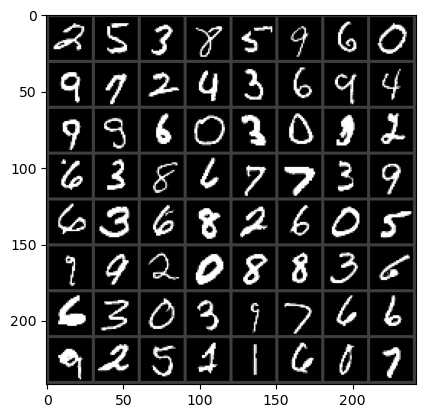

In [7]:
import torchvision
def imshow(img):
    img=img+0.5/2
    img=img.numpy()
    plt.imshow(np.transpose(img,(1,2,0)))
    plt.show()
img,labels=next(iter(train_loader))
imshow(torchvision.utils.make_grid(img))

In [8]:
class ConvAutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, 3, stride=3,padding=1),
            nn.ReLU(True),
            nn.MaxPool2d(2, stride=2),
            nn.Conv2d(32, 64, 3, stride=2,padding=1),
            nn.ReLU(True),
            nn.MaxPool2d(2, stride=1)
            )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 3,stride=2),
            nn.ReLU(True),
            nn.ConvTranspose2d(32, 16, 5, stride=3,padding=1),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 1, 2,stride=2,padding=1),
            nn.Tanh())
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
        

In [9]:
model = ConvAutoEncoder()
!pip install torch_summary
from torchsummary import summary
summary(model, torch.zeros(2,1,28,28));

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 64, 2, 2]            --
|    └─Conv2d: 2-1                       [-1, 32, 10, 10]          320
|    └─ReLU: 2-2                         [-1, 32, 10, 10]          --
|    └─MaxPool2d: 2-3                    [-1, 32, 5, 5]            --
|    └─Conv2d: 2-4                       [-1, 64, 3, 3]            18,496
|    └─ReLU: 2-5                         [-1, 64, 3, 3]            --
|    └─MaxPool2d: 2-6                    [-1, 64, 2, 2]            --
├─Sequential: 1-2                        [-1, 1, 28, 28]           --
|    └─ConvTranspose2d: 2-7              [-1, 32, 5, 5]            18,464
|    └─ReLU: 2-8                         [-1, 32, 5, 5]            --
|    └─ConvTranspose2d: 2-9              [-1, 16, 15, 15]          12,816
|    └─ReLU: 2-10                        [-1, 16, 15, 15]          --
|    └─ConvTranspose2d: 2-11             [-1, 1, 28, 28]           65
| 

In [10]:

criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(),lr=0.001, weight_decay=1e-5)

In [11]:

# Training loop
def train(model, train_loader, criterion, optimizer):
    model.train()
    train_loss = 0
    for data, _ in train_loader:
        optimizer.zero_grad()
        recon = model(data)
        loss = criterion(recon, data)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * len(data)
    train_loss /= len(train_loader.dataset)
    return train_loss

# Validation loop
def validate(model, val_loader, criterion):
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for data, _ in val_loader:
            recon = model(data)
            loss = criterion(recon, data)
            val_loss += loss.item() * len(data)
        val_loss /= len(val_loader.dataset)
    return val_loss

# Train the model
num_epochs = 10
for epoch in range(num_epochs):
    train_loss = train(model, train_loader, criterion, optimizer)
    val_loss = validate(model, val_loader, criterion)
    print(f'Epoch [{epoch+1}/{num_epochs}], '
          f'train loss: {train_loss:.4f},val loss: {val_loss:.4f},')

Epoch [1/10], train loss: 0.2700,val loss: 0.0951,
Epoch [2/10], train loss: 0.0825,val loss: 0.0708,
Epoch [3/10], train loss: 0.0680,val loss: 0.0615,
Epoch [4/10], train loss: 0.0614,val loss: 0.0573,
Epoch [5/10], train loss: 0.0574,val loss: 0.0541,
Epoch [6/10], train loss: 0.0544,val loss: 0.0514,
Epoch [7/10], train loss: 0.0522,val loss: 0.0514,
Epoch [8/10], train loss: 0.0506,val loss: 0.0486,
Epoch [9/10], train loss: 0.0492,val loss: 0.0476,
Epoch [10/10], train loss: 0.0480,val loss: 0.0467,


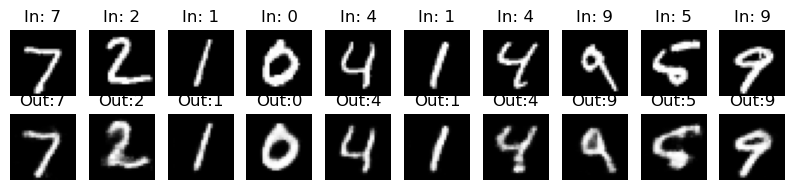

In [13]:
def visualize(model, test_loader):
    model.eval()
    with torch.no_grad():
        for data, labels in test_loader:
            #data = data.view(data.size(0), -1)  # flatten input tensor
            recon = model(data)
            break
    fig, axes = plt.subplots(nrows=2, ncols=10, figsize=(10, 2))
    for i in range(10):
        axes[0][i].imshow(data[i].view(28, 28), cmap='gray',)
        axes[0][i].axis('off')
        axes[0][i].set_title(f'In: {labels[i]}')
        axes[1][i].imshow(recon[i][0].view(28, 28), cmap='gray')
        axes[1][i].axis('off')
        axes[1][i].set_title(f'Out:{labels[i]}')
    plt.savefig('ConvEncoderResult.jpg')
    plt.show()

visualize(model, val_loader)


In [23]:
from tqdm import tqdm

latent_vectors=[]
classes=[]
for im,clss in tqdm(val_loader):
    latent_vectors.append(model.encoder(im).view(len(im),-1))
    classes.extend(clss)
latent_vectors=torch.cat(latent_vectors).cpu().detach().numpy()
    

100%|██████████| 156/156 [00:02<00:00, 62.12it/s]


In [24]:
from sklearn.manifold import TSNE
tsne=TSNE(2)


In [25]:
clustered=tsne.fit_transform(latent_vectors)

/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


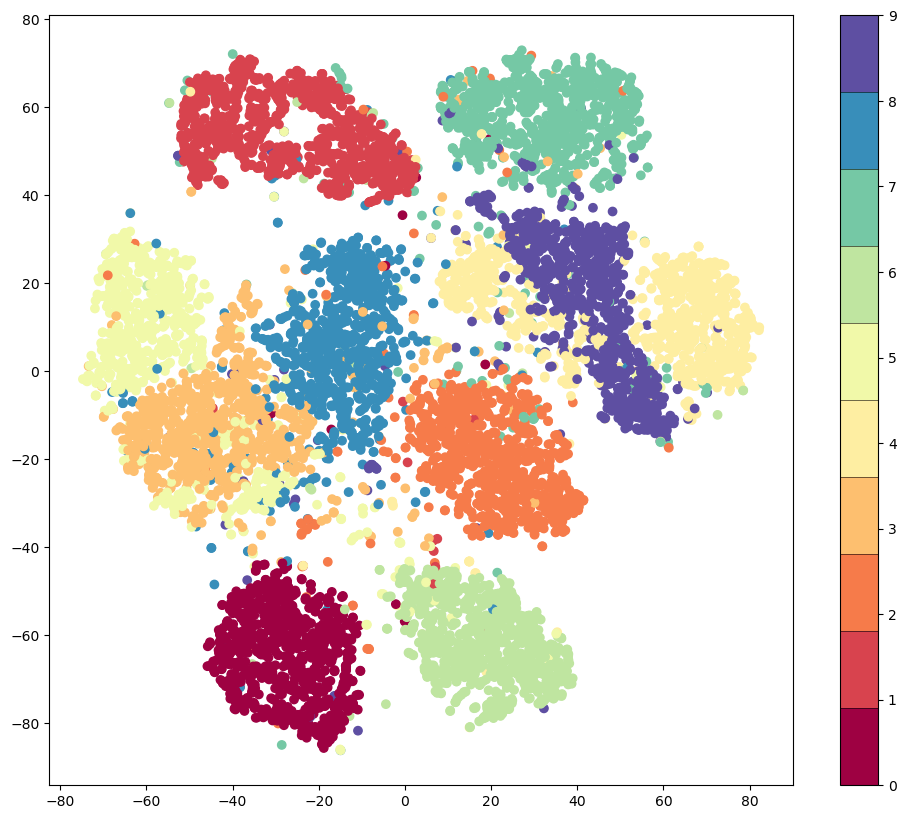

In [26]:
fig = plt.figure(figsize=(12,10))
cmap = plt.get_cmap('Spectral', 10)
plt.scatter(*zip(*clustered), c=classes, cmap=cmap)
plt.colorbar(drawedges=True)
plt.savefig('Clustered Class.jpg')
plt.show()